# 01 – Parsing verification: IR baseline vs jaw movement

Load 50 Hz session data, plot the **IR** channel alongside **accel_z** (jaw movement). Apply a **0.5 Hz low-pass** to the IR channel to show the DC trend (hemodynamic baseline). We look for a **drop in the IR baseline** that correlates with **jaw movement** in the accelerometer (clenching/occlusion per .cursorrules).

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

processed_dir = Path("../data/processed")
if not processed_dir.exists():
    processed_dir = Path("data/processed")
csv_path = processed_dir / "session_50hz.csv"

df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index)
print(f"Loaded {len(df)} rows at 50 Hz")
df.head()

Loaded 7070 rows at 50 Hz


,green,red,ir,accel_x,accel_y,accel_z
datetime,,,,,,
1970-01-01 06:39:58.480,25788.3000,0.0,25518.900,0.0,4448.0000,0.0
1970-01-01 06:39:58.500,25559.5725,0.0,25276.115,0.0,4247.7425,0.0
1970-01-01 06:39:58.520,25330.8450,0.0,25033.330,0.0,4047.4850,0.0
1970-01-01 06:39:58.540,25102.1175,0.0,24790.545,0.0,3847.2275,0.0
1970-01-01 06:39:58.560,24873.3900,0.0,24547.760,0.0,3646.9700,0.0


## IR and accel_z (raw)

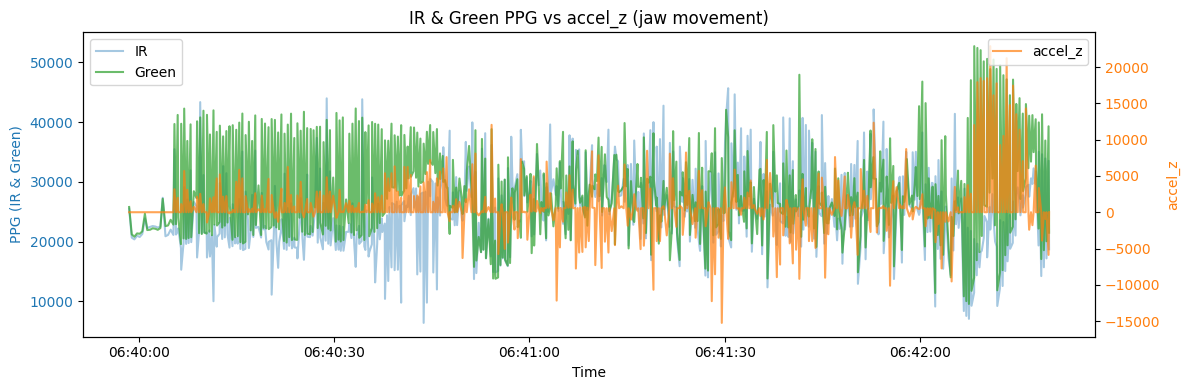

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(df.index, df["ir"],    color="C0", alpha=0.4, label="IR")
ax1.plot(df.index, df["green"], color="C2", alpha=0.7, label="Green")
ax1.set_ylabel("PPG (IR & Green)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df.index, df["accel_z"], color="C1", alpha=0.7, label="accel_z")
ax2.set_ylabel("accel_z", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")
ax2.legend(loc="upper right")

ax1.set_xlabel("Time")
plt.title("IR & Green PPG vs accel_z (jaw movement)")
plt.tight_layout()
plt.show()

## 0.5 Hz low-pass on IR (DC trend)

Butterworth low-pass at 0.5 Hz to extract the DC / baseline trend (muscle occlusion).

In [18]:
fs = 50  # Hz
order = 4
nyq = fs / 2

# IR: low-pass < 1 Hz (DC / baseline per .cursorrules)
cutoff_lp = 0.8  # Hz, below 1 Hz
b_lp, a_lp = butter(order, cutoff_lp / nyq, btype="low")

ir_dc    = filtfilt(b_lp, a_lp, df["ir"].values)
green_dc = filtfilt(b_lp, a_lp, df["green"].values)

df["ir_dc"]    = ir_dc
_df = df  # keep for clarity
_df["green_dc"] = green_dc

# Green: bandpass 0.5–8.0 Hz for clean pulsatile component (heart rate / morphology)
low_bp, high_bp = 0.5, 8.0
b_bp, a_bp = butter(order, [low_bp / nyq, high_bp / nyq], btype="band")

green_bp = filtfilt(b_bp, a_bp, df["green"].values)
_df["green_bp"] = green_bp

print("IR DC trend (<1 Hz LP) added as 'ir_dc'.")
print("Green DC trend (<1 Hz LP) added as 'green_dc'.")
print("Green bandpass (0.5–8 Hz) added as 'green_bp'.")

IR DC trend (<1 Hz LP) added as 'ir_dc'.
Green DC trend (<1 Hz LP) added as 'green_dc'.
Green bandpass (0.5–8 Hz) added as 'green_bp'.


## IR DC trend vs accel_z

Look for a **drop in the IR baseline** (DC trough) that lines up with **jaw movement** (accel_z).

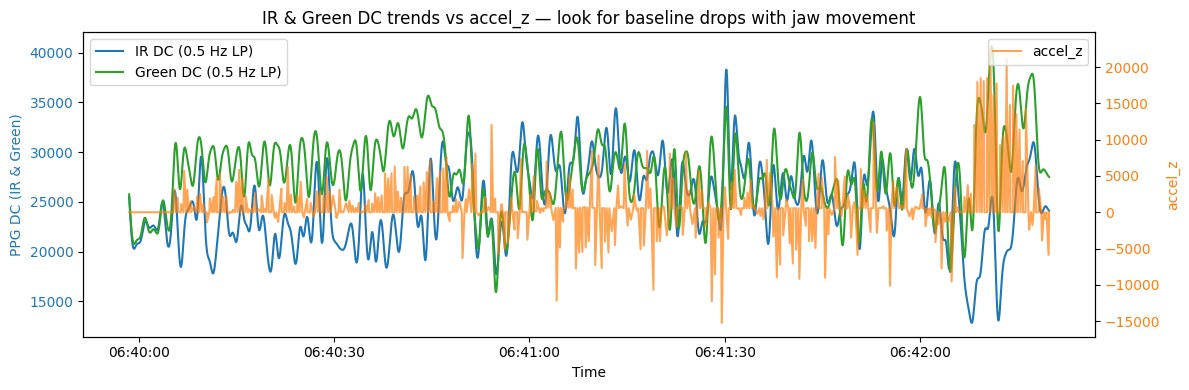

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(df.index, df["ir_dc"],    color="C0", label="IR DC (0.5 Hz LP)")
ax1.plot(df.index, df["green_dc"], color="C2", label="Green DC (0.5 Hz LP)")
ax1.set_ylabel("PPG DC (IR & Green)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df.index, df["accel_z"], color="C1", alpha=0.7, label="accel_z")
ax2.set_ylabel("accel_z", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")
ax2.legend(loc="upper right")

ax1.set_xlabel("Time")
plt.title("IR & Green DC trends vs accel_z — look for baseline drops with jaw movement")
plt.tight_layout()
plt.show()

## Overlay: IR raw, IR DC, accel_z

All three on one figure (IR and IR DC on left axis, accel_z on right).

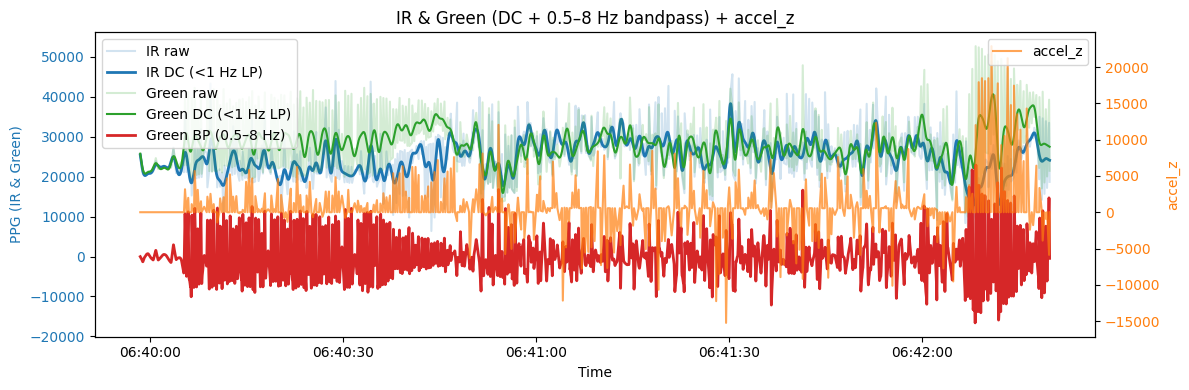

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 4))
# IR raw + DC
ax1.plot(df.index, df["ir"],    color="C0", alpha=0.2, label="IR raw")
ax1.plot(df.index, df["ir_dc"], color="C0", lw=2,   label="IR DC (<1 Hz LP)")
# Green raw + DC + bandpass
ax1.plot(df.index, df["green"],    color="C2", alpha=0.2, label="Green raw")
ax1.plot(df.index, df["green_dc"], color="C2", lw=1.5, label="Green DC (<1 Hz LP)")
ax1.plot(df.index, df["green_bp"], color="C3", lw=2,   label="Green BP (0.5–8 Hz)")

ax1.set_ylabel("PPG (IR & Green)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df.index, df["accel_z"], color="C1", alpha=0.7, label="accel_z")
ax2.set_ylabel("accel_z", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")
ax2.legend(loc="upper right")

ax1.set_xlabel("Time")
plt.title("IR & Green (DC + 0.5–8 Hz bandpass) + accel_z")
plt.tight_layout()
plt.show()